In [184]:
from __future__ import print_function, division
%reload_ext autoreload
%autoreload 2

from scipy.stats import gaussian_kde, kde
import pandas as pd
import seaborn as sns

import numpy as np

from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras import layers, regularizers

from tqdm import tqdm
from glob import glob
import datetime
import os, sys
from enum import Enum

pd.options.display.max_rows = 15
pd.options.display.max_columns = 20

from collections import OrderedDict

## some useful team data in here (converters from short to long):
from basketball_reference_web_scraper import data

years = np.arange(1950, 2019)

## custom printing for my Keras training:
class PrintCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 25 == 0:
            print("epoch {}:  loss = {:.2f}, test loss = {:.2f}".format(
                epoch, logs['loss'], logs['val_loss']))
    def on_train_begin(self, logs={}):
        print("Beginning training...")
    
    def on_train_end(self, logs):
        print("Training completed")
        
def create_unique_id(row):
    return row['player_id'] + '-' + data.Team(row['team']).name


def drop_common_columns_from_df2(df1, df2, skip=['team']):
    columns_to_drop = list(filter(lambda x:  x not in skip, 
                         np.intersect1d(list(df1.keys()), list(df2.keys()))))
    
    return df2.drop(columns=columns_to_drop)

def find_player_id(player_name, df):
    possible_pids = np.unique(df.index[df['player_name'] == player_name])
    if possible_pids.size == 1:
        return possible_pids[0]
    elif possible_pids.size > 1:
        print("Many options; returning most average points:")
        vals = []
        for pid in possible_pids:
            rows = df.loc[df.index==pid]
            mean_points = np.average(rows['points'])
            vals.append(mean_points)
            print(f'\t{pid} with an average point/year of {mean_points}'.format(
                row['PlayerID'], row['CareerValue']))
        return possible_pids[np.argmax(vals)]
    else:
        print("No exact name matches... possible names:")
        from fuzzywuzzy import process
        matches = process.extract(player_name, np.unique(df['player_name'].values), limit=10)
        for poss in matches:
            print("\t",poss[0])
        print("Returning best match, but maybe incorrect...")
        return find_player_id(matches[0][0], df)
    
class CyclicList(list):
    def __getitem__(self, index):
        return super().__getitem__(index%len(self))

In [191]:
np.average?

In [241]:
columns_to_rate = ['minutes_played', 'made_field_goals', 'attempted_field_goals', 
                  'made_three_point_field_goals', 'attempted_three_point_field_goals', 
                  'made_two_point_field_goals', 'attempted_two_point_field_goals', 
                  'made_free_throws', 'attempted_free_throws', 'offensive_rebounds',
                  'defensive_rebounds', 'total_rebounds', 'assists', 'steals', 'blocks',
                  'turnovers', 'personal_fouls', 'points']

def add_rate_stats(df, columns=columns_to_rate):
    for column in columns_to_rate:
        df[column+'_per_game'] = df[column]/df['games_played']
        df[column+'_per_game.playoffs'] = df[column+'.playoffs']/df['games_played.playoffs']

        df[column+'_per_36_minutes'] = 36 * df[column]/df['minutes_played']
        df[column+'_per_36_minutes.playoffs'] = 36 * df[column+'.playoffs']/df['minutes_played.playoffs']        
    return df

advanced_stats_to_combine = ['vorp', 'total_box_plus_minus', 
                             'total_win_shares', 'total_win_shares_per_48',
                            'offensive_rating', 'defensive_rating', 
                            'effective_field_goal_percent', 'true_shooting_percent',
                            ]

def add_combined_RSPO_stats(df, 
                             columns=advanced_stats_to_combine, 
                             playoffs_weight=1.5):
    
    for column in advanced_stats_to_combine:
        ## take the larger of the regular season and 
        ## the weighted average between playoffs and RS
        ## i.e. the playoffs can help, but can't hurt
        ## if there's a playoff val and no RS val, jsut use the playoff val
        rs_val = df[column]
        if np.isnan(rs_val).all():
            df[column+'.combined'] = np.array([np.nan]*len(df))
        else:
            po_val = df[column+'.playoffs']
            average = np.average([rs_val, po_val], weights=[1, playoffs_weight], axis=0)
            res = np.nanmax([rs_val, average], axis=0)
            msk = np.isnan(res)
            res[msk] = po_val[msk]
            df[column+'.combined'] = res
    return df
        
def drop_nontot_rows_for_traded_players(df):
    pids_with_totals = df.index[df['team'] == 'TOTAL']
    for pid in pids_with_totals:
        rows = df.loc[(df.index == pid) & (df['team'] != 'TOTAL')]
        df.drop(index=rows.index, inplace=True)
    return df

In [242]:
def parse_year(year):
    df = pd.read_csv(f'scraped/stats_by_year/{year}_totals.csv')

    ## merge in the advanced df, joining on all columns 
    ## in common and asserting they're all the same
    df = df.merge(right=pd.read_csv(f'scraped/stats_by_year/{year}_advanced.csv'), sort=False)

    ## do the same for the per 100 if it's available:
    if year >= 1974:
        df = df.merge(right=pd.read_csv(f'scraped/stats_by_year/{year}_per100.csv'), sort=False)
    else:
        column_headers = pd.read_csv('scraped/stats_by_year/1974_per100.csv').keys()
        right = pd.concat([pd.Series(data=[np.nan]*len(df), name=k) for k in column_headers if k not in df], axis=1)
        right.set_index(df.index)
        df = df.join(right, sort=False)

    ## drop rows corresponding to a single team in a multi-team 
    ## season for a single player
    df = drop_nontot_rows_for_traded_players(df)

    ## now do almost all of that for the playoff stats too:
    dfp = pd.read_csv(f'scraped/stats_by_year/{year}_playoffs_totals.csv')
    dfp = dfp.merge(right=pd.read_csv(f'scraped/stats_by_year/{year}_playoffs_advanced.csv'), sort=False)
    if year >= 1974:
        dfp = dfp.merge(right=pd.read_csv(f'scraped/stats_by_year/{year}_playoffs_per100.csv'), sort=False)    
    else:
        right = pd.concat([pd.Series(data=[np.nan]*len(dfp), name=k) for k in column_headers if k not in dfp], axis=1)
        right.set_index(dfp.index)
        dfp = dfp.join(right, sort=False)        

    ## rename the columns to have playoffs in it:
    mapper = {k: k+'.playoffs' for k in dfp.keys()}
    for k in ['age', 'player_name', 'positions', 'team', 'player_id']:
        mapper[k] = k

    dfp.rename(columns=mapper, inplace=True)

    ## now merge the two together, filling in any missing 
    ## values (i.e. playoff stats for players that didn't 
    ## make the playoffs) with NaNs:
    out = pd.merge(df, dfp, how='outer')

    ## index by the ID of the player
    out.set_index('player_id', inplace=True)

    ## drop any players that didn't play any minutes in either RS or playoffs 
    ## (not sure there are any included, but let's do it anyway...)
    row_mask = np.isnan(out['minutes_played']) & np.isnan(out['minutes_played.playoffs'])
    if np.count_nonzero(row_mask):
        print(f"Dropping {np.count_nonzero(row_mask)} players that had no minutes in the RS or POs")
        out.dropna(axis=0, subset=['minutes_played', 'minutes_played.playoffs'], how='all', inplace=True)
    
    ## now add per game and per 36 minutes stats:
    out = add_rate_stats(out)
    
    ## now add combined regular season and playoff stats:
    out = add_combined_RSPO_stats(out)
    
    return out

In [243]:
dataframes_by_year = {}
for year in tqdm(years):
    df = parse_year(year)
    df['season_end_year'] = year
    dataframes_by_year[year] = df
    
all_years = pd.concat(dataframes_by_year.values())
all_years.sort_values(by='season_end_year', axis=0, inplace=True)

100%|██████████| 69/69 [00:10<00:00,  5.00it/s]


Note -- a lot of advanced stats are missing prior to 1974.  'win_shares' exists for all years, but vorp does not.

In [245]:
all_years.shape

(25374, 213)

Great!  Let's go ahead and save that dataframe:

In [246]:
all_years.to_hdf('scraped/all_years_combined.hdf5', 'nba_stats')

In [120]:
all_players = np.unique(all_years.index)

In [121]:
all_years.keys()

Index(['player_name', 'positions', 'age', 'team', 'games_played',
       'games_started', 'minutes_played', 'made_field_goals',
       'attempted_field_goals', 'field_goal_percent',
       ...
       'turnovers_per_36_minutes.playoffs', 'personal_fouls_per_game',
       'personal_fouls_per_game.playoffs', 'personal_fouls_per_36_minutes',
       'personal_fouls_per_36_minutes.playoffs', 'points_per_game',
       'points_per_game.playoffs', 'points_per_36_minutes',
       'points_per_36_minutes.playoffs', 'season_end_year'],
      dtype='object', length=205)

In [ ]:
from sgklibs.histograms import anticum_hist

In [ ]:
fig = plt.figure(figsize=(13,13))
ax = plt.gca()
for year in years:
    hist, bins = anticum_hist(all_years['points'][all_years['season_end_year']==year])
    ax.loglog(bins, hist)

ax.set(xlim)

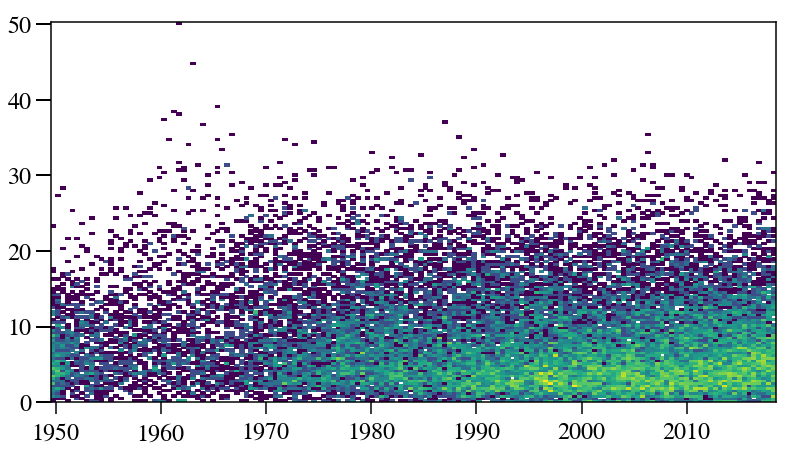

In [40]:
fig = plt.figure(figsize=(13, 7))
ax = plt.gca()

msk = (np.isfinite(all_years['points_per_game']))
y = all_years['points_per_game'][msk]
x = all_years['season_end_year'][msk]

noise = np.random.random(x.size) - 0.5

# sns.violinplot(x, y, cut=0, )

# sns.kdeplot(x, y, shade=True, ax=ax, nlevels=128, cmap="viridis")

hist = ax.hist2d(x+noise, y, norm=mpl.colors.LogNorm(), bins=150)

# sns.boxplot(x, y, ax=ax)


# xticklabels = ax.get_xticklabels()[::10]
# ax.set_xticks(ax.get_xticks()[::10])
# ax.set_xticklabels(xticklabels)

# nbins=300
# k = kde.gaussian_kde([x,y])
# xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
# zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
# ax.pcolormesh(xi, yi, zi.reshape(xi.shape), norm=mpl.colors.LogNorm())

In [59]:
loc = all_years['player_name'] == 'LeBron James'
rows = all_years.loc[loc]

In [64]:
rows['player_name'].iloc[0]

'LeBron James'

In [251]:
markers = CyclicList(['s', 'v', 'd', 'h', 'o'])
colors = CyclicList(sns.color_palette(n_colors=8))
def plot_player_career_stat(df, player_id_or_name_list, stat='vorp', 
                            year_limits=[1950, 2019], 
                            legend_outside_axes=False, ylim=None):
    if np.isscalar(player_id_or_name_list):
        player_id_or_name_list = [player_id_or_name_list]
    
    fig = plt.figure(figsize=(13, 7))
    ax = plt.gca()
    
    msk = np.isfinite(df[stat])
    
    x = df['season_end_year'][msk]
    y = df[stat][msk]
    
    noise = np.random.random(x.size) - 0.5
    x = x + noise
    
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    cmap = 'viridis'
    im = ax.scatter(x, y, c=z, marker='o', s=12, norm=mpl.colors.LogNorm(), cmap=cmap, label='_nolegend_')
#     cbar = fig.colorbar(im, ax=ax)
    
    for ii, player_id_or_name in enumerate(player_id_or_name_list):
        if player_id_or_name in all_players:
            loc = df.index == player_id_or_name
        else:
            loc = df['player_name'] == player_id_or_name

        rows = df.loc[loc]
        if not rows.size:
            print(f"nobody found by the name or id of {player_id_or_name}...finding closest possibility...")
            player_id = find_player_id(player_id_or_name, df)
            loc = df.index == player_id
            rows = df.loc[loc]

        player_name = rows['player_name'].iloc[0]
        xv = rows['season_end_year']
        yv = rows[stat]

        ax.plot(xv, yv, marker=markers[ii], color=colors[ii], markersize=10, label=player_name)

    ax.set_xlim(year_limits)    
    ax.set_xlabel('Year')
    ax.set_ylabel(stat)
    
    if ylim is not None:
        ax.set_ylim(ylim)
    
    if legend_outside_axes:
        ax.legend(loc=(1.025, 0))
    else:
        ax.legend(fontsize=18)
    
    ax.grid(lw=0.25, ls='-')
        
    return fig, ax

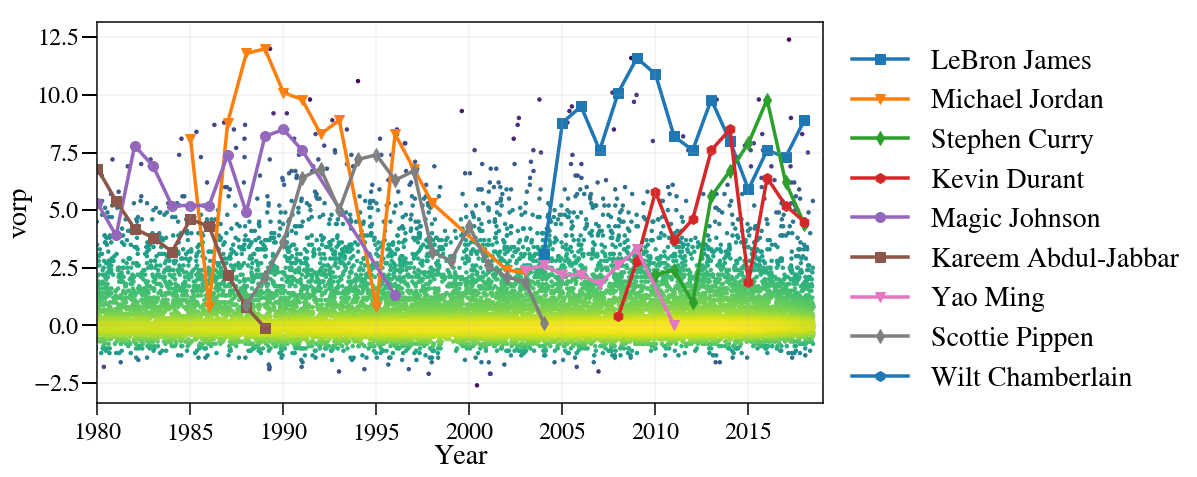

In [188]:
fig, ax = plot_player_career_stat(all_years, 
          ['LeBron James', 'Michael Jordan', 'Stephen Curry', 'Kevin Durant', 'Magic Johnson', 
           'Kareem Abdul-Jabbar', 'Yao Ming', 'Scottie Pippen', 'Wilt Chamberlain'], legend_outside_axes=True,
                                  year_limits=[1980, 2019])

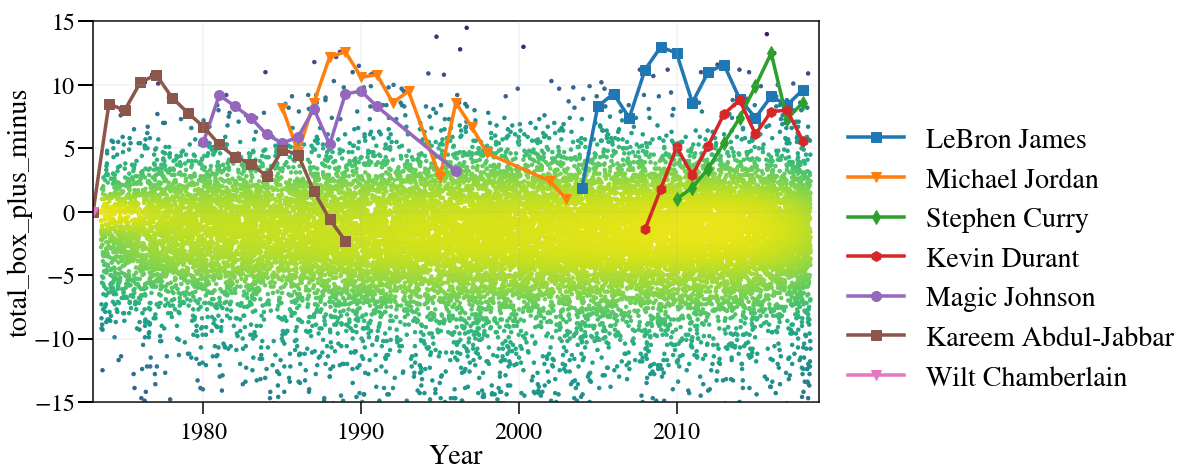

In [253]:
fig, ax = plot_player_career_stat(all_years, 
          ['LeBron James', 'Michael Jordan', 'Stephen Curry', 'Kevin Durant', 'Magic Johnson', 
           'Kareem Abdul-Jabbar', 'Wilt Chamberlain'], legend_outside_axes=True,
                                  stat='total_box_plus_minus', year_limits=[1973, 2019],
                                 ylim=[-15, 15])

In [254]:
stars = ['LeBron James', 'Michael Jordan', 'Kobe Bryant', "Shaquille O'Neal", 
         'Magic Johnson', 'Kareem Abdul-Jabbar', 'Larry Bird', 'Wilt Chamberlain',
        'Tim Duncan', 'Stephen Curry', 'Kevin Durant']

nobody found by the name or id of Kobe Bryan...finding closest possibility...
No exact name matches... possible names:
	 Kobe Bryant
	 Joe Bryant
	 Em Bryant
	 Bryn Forbes
	 Patrick O'Bryant
	 Bob Brannum
	 Mark Bryant
	 Brian Roberts
	 Bryan Warrick
	 Torgeir Bryn
Returning best match, but maybe incorrect...


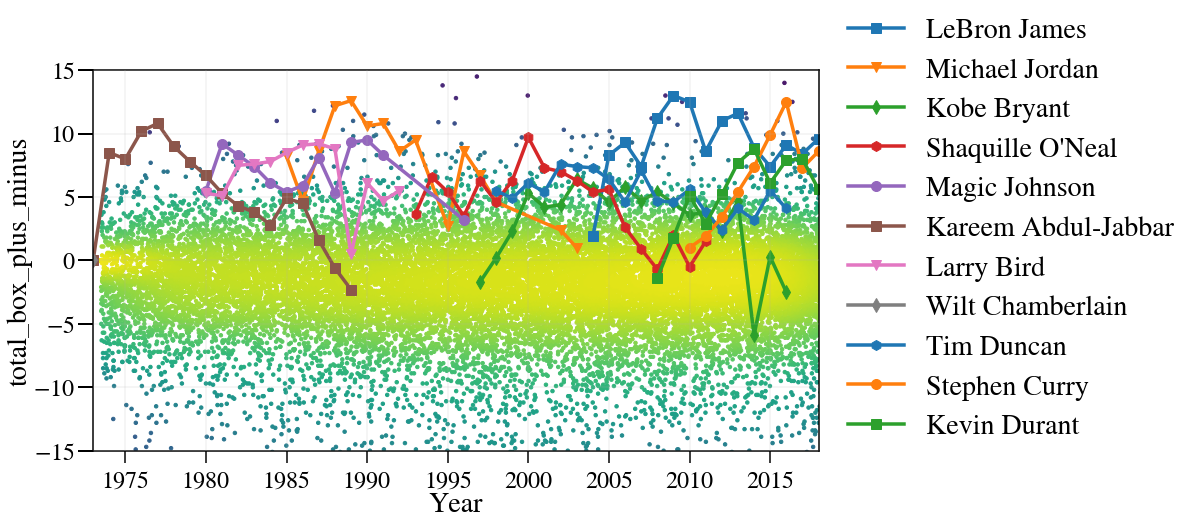

In [255]:
fig, ax = plot_player_career_stat(all_years, stars, 
                                  legend_outside_axes=True,
                                  stat='total_box_plus_minus',
                                  year_limits=[1973, 2018],
                                  ylim=[-15, 15],
                                 )

In [ ]:
def parse_year_old(year):
    tot_df = pd.read_csv(f'scraped/stats_by_year/{year}_totals.csv')
    adv_df = pd.read_csv(f'scraped/stats_by_year/{year}_advanced.csv')

    ## set the index to the player id to match up later and avoid dropping them
    tot_df.set_index('player_id', inplace=True)
    adv_df.set_index('player_id', inplace=True)

    ## drop column in common other than team:
    columns_to_drop = list(filter(lambda x:  x != 'team', 
                             np.intersect1d(list(tot_df.keys()), list(adv_df.keys()))))

#     print("Dropping: "+", ".join(columns_to_drop)+" from advanced df")
    adv_df.drop(columns=columns_to_drop, inplace=True)

    ## drop rows corresponding to a single team in a multi-team season
    pids_with_totals = tot_df.index[tot_df['team'] == 'TOTAL']
    for pid in pids_with_totals:
        for df in [tot_df, adv_df]:
            rows = df.loc[(df.index == pid) & (df['team'] != 'TOTAL')]
            df.drop(index=rows.index, inplace=True)

    ## now drop team from advanced df and concatenate the dataframes alongside each other
    rs_out = pd.concat((tot_df, adv_df.drop(columns='team')), axis=1) 

    ### make sure we have an entirely unique player list
    assert np.unique(rs_out.index).shape == rs_out.index.shape
    
    ## now read in stats from the playoffs:

    ## ensure none of our columns are duplicating data
    ## which would indidcate a problem when scraping
    ## actually, don't do this, because there are cases where we expect a bunch of zeros 
    ## (e.g. missing stats, no 3 pointers, etc)
    #     columns = list(rs_out.keys())
#     for ii, col in enumerate(columns):
#         if ii == len(columns) - 1:
#             continue

#         v1 = rs_out[col].values
#         for ocol in columns[ii+1:]:
#             v2 = rs_out[ocol].values
#             try:
#                 assert ((not (v1==v2).all()) or (v1==0).all())
#             except Exception as e:
#                 print(col, ocol)
#                 raise e
    
    return rs_out

### Stuff related to the playoffs before I decided to drop it for now...

In [ ]:

## now handle the playoffs:
directory = f'scraped/playoffs_by_series/{year}/'
files = glob(directory+'/*_basic.csv')

### files with an _0_, _1_, etc have been combined into those without, so skip any that have that
basic_files = list(filter(lambda fname: True not in [f'_{x}_' in fname for x in range(10)], 
                     files))
playoff_series_files = {}

for fn in basic_files:
    series = fn.split('/')[-1][:-len('_basic.csv')]
    if series == 'Finals':
        playoff_series_files['Finals'] = [fn]
    else:
        series = series.split(maxsplit=1)[-1]
        if series in playoff_series_files:
            playoff_series_files[series].append(fn)
        else:
            playoff_series_files[series] = [fn]

assert len(playoff_series_files['Finals']) == 1

def read_avail_series_tables(fn):
    tot_df = pd.read_csv(fn)
    tot_df.set_index('player_id', inplace=True)
    if os.path.isfile(fn.replace('_basic', '_advanced')):
        adv_df = pd.read_csv(fn.replace('_basic', '_advanced'))
        adv_df.set_index('player_id', inplace=True)

        ## drop column in common (including teams, cause no tot rows here):
        columns_to_drop = np.intersect1d(list(tot_df.keys()), list(adv_df.keys()))
        adv_df.drop(columns=columns_to_drop, inplace=True)
        
        df = pd.concat((tot_df, adv_df), axis=1)
        return df
    else:
        return tot_df
        


series_dataframes = {}
for series in playoff_series_files:
    for ii, fn in enumerate(playoff_series_files[series]):
        if ii == 0:
            df = read_avail_series_tables(fn)
        else:
            new_df = read_avail_series_tables(fn)
            df = pd.concat((df, new_df), axis='index')
    series_dataframes[series] = df

## now have to figure out which round we're in
## easiest way is to count the number of players who participated
## since that will roughly halve every round
series_to_round_number = {}
series_by_length = {series_dataframes[series].shape[0]: series for series in playoff_series_files}
sorted_lengths = sorted(series_by_length.keys())[::-1]

rn = 1
for l in sorted_lengths:
    series = series_by_length[l]
    series_to_round_number[series] = rn
    rn = rn + 1

all_series_df = None
for l in sorted_lengths:
    series = series_by_length[l]
    rn = series_to_round_number[series]

    df = series_dataframes[series]

    columns = df.keys()
    columns_remapper = {c: c + '_round'+str(series_to_round_number[series]) for c in columns if c != 'player_name'}
    df.rename(columns=columns_remapper, inplace=True)
    df.drop(columns='player_name', inplace=True)

    if all_series_df is None:
        all_series_df = pd.DataFrame(df, copy=True)
    else:
        all_series_df = pd.concat((all_series_df, df), axis=1, sort=False)

## now put that alongside the regular season stats...hmm, this isn't working
out = pd.concat((rs_out, all_series_df), axis=1, sort=False)